In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ir_measures import RR, R, nDCG, read_trec_run
import ir_datasets
import json
import gzip

In [8]:
qrels_dl19 = list(ir_datasets.load('msmarco-passage/trec-dl-2019').qrels)
qrels_devs = list(ir_datasets.load('msmarco-passage/dev/small').qrels)
df = []
for n in [100, 500, 1000]:
    for nn in [64, 128]:
        for d in [10,20,50,100]:
            id = f'ladr.num_results-{n}.num_neighbours-{nn}.depth-{d}'
            latency = float(open(f'results/devs.{id}.time').read())
            res_dl19 = json.load(gzip.open(f'results/dl19.{id}.run.gz.measures.json.gz'))
            res_devs = json.load(gzip.open(f'results/devs.{id}.run.gz.measures.json.gz'))
            # run_devs = list(read_trec_run(f'results/devs.{id}.run.gz'))
            df.append({
                'num_results': n,
                'num_neighbours': nn,
                'depth': d,
                'devs_latency': latency,
                'dl19_ndcg10': res_dl19['avg']['nDCG@10'],
                'dl19_ndcg1k': res_dl19['avg']['nDCG@1000'],
                'dl19_r1k': res_dl19['avg']['R(rel=2)@1000'],
                'dl19_rbo99': res_dl19['avg']['RBO(p=0.99)'],
                # 'dl20_ndcg10': res_dl20['avg']['nDCG@10'],
                # 'dl20_ndcg1k': res_dl20['avg']['nDCG@1000'],
                # 'dl20_r1k': res_dl20['avg']['R(rel=2)@1000'],
                # 'dl20_rbo99': res_dl20['avg']['RBO(p=0.99)'],
                'devs_rr10': res_devs['avg']['RR@10'],
                'devs_r1k': res_devs['avg']['R@1000'],
                'devs_rbo99': res_devs['avg']['RBO(p=0.99)'],
            })
df = pd.DataFrame(df)

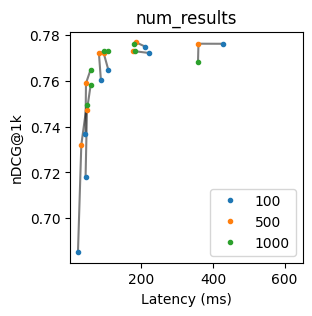

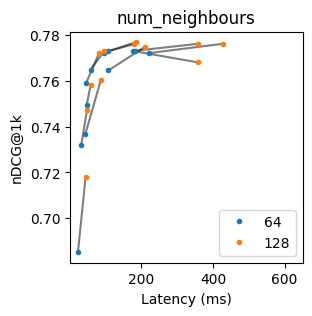

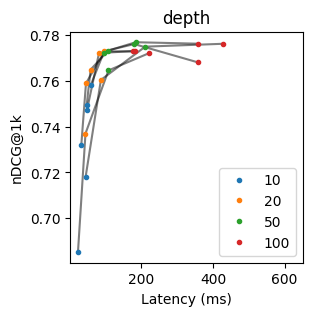

In [13]:
# measure = 'devs_rbo99'
measure = 'dl19_ndcg1k'

for factor in ['num_results', 'num_neighbours', 'depth']:
    fig, ax = plt.subplots(figsize=(3,3))
    others = {'num_results', 'num_neighbours', 'depth'}
    others.discard(factor)
    for key, sub_df in df.groupby(list(others)):
        ax.plot(sub_df.devs_latency, sub_df[measure], c='k', alpha=0.5)
        # ax.set_xscale('log')
    for i, (key, sub_df) in enumerate(df.groupby(factor)):
        ax.plot(sub_df.devs_latency, sub_df[measure], '.', label=f'{key}')
    ax.set_title({'cst': '$t_{cs}$', 'ncells': 'nprobe'}.get(factor, factor))
    ax.set_xlim(1, 650)
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('nDCG@1k')
    ax.legend()